In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
tb.__version__

'0.0.3.13'

In [3]:
EXPERIMENT_NAME = '1122-Scene1-LSTM-SmallWindow-UseDD'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene1_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene1_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
WINDOW_SIZE = 48

In [5]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z',
                      'dyaw', 'dpitch', 'droll',
                      'ddyaw', 'ddpitch', 'ddroll']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [6]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [7]:
len(ds_train), len(ds_test)

(18453, 19170)

In [8]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 12]), torch.Size([3]))

In [9]:
x, y = ds_train[0]

In [10]:
x.shape

torch.Size([48, 12])

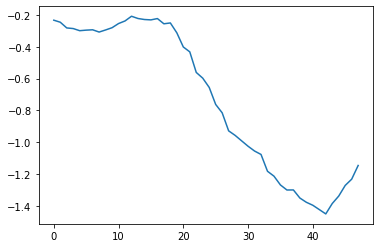

In [11]:
plt.plot(x[:, 2])

In [12]:
model = utils.BaselineLSTM(input_size=12,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.2,
                           bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.537110
 - Pitch        :  11.924340
 - Roll         :   3.118917
 - RMS          :   8.997666
 - 99% Tile     :  43.799921
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.341599
 - Pitch        :   8.767802
 - Roll         :   3.099694
 - RMS          :   7.610255
 - 99% Tile     :  41.204304
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.352839
 - Pitch        :   7.896107
 - Roll         :   3.106461
 - RMS          :   7.290958
 - 99% Tile     :  39.298195
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   7.874495
 - Pitch        :   7.260506
 - Roll         :   3.026838
 - RMS          :   6.426102
 - 99% Tile     :  34.622778
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.486849
 - Pitch        :   5.555560
 - Roll         :   3.029446
 - RMS          :   4.835538
 - 99% Tile     :  32.003156
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.296680
 - Pitch        :   4.272532
 - Roll         :   2.949437
 - RMS          :   3.890808
 - 99% Tile     :  28.919629
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.467884
 - Pitch        :   3.450535
 - Roll         :   2.854094
 - RMS          :   3.269978
 - 99% Tile     :  26.346364
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.014451
 - Pitch        :   2.945239
 - Roll         :   2.814729
 - RMS          :   2.925978
 - 99% Tile     :  24.171668
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.898347
 - Pitch        :   2.530955
 - Roll         :   2.785728
 - RMS          :   2.742652
 - 99% Tile     :  22.048848
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.483091
 - Pitch        :   2.151768
 - Roll         :   2.819272
 - RMS          :   2.499609
 - 99% Tile     :  20.061590
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.184883
 - Pitch        :   2.095177
 - Roll         :   2.805111
 - RMS          :   2.382725
 - 99% Tile     :  18.488096
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.002590
 - Pitch        :   1.857145
 - Roll         :   2.659763
 - RMS          :   2.201037
 - 99% Tile     :  17.102741
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.295114
 - Pitch        :   1.849115
 - Roll         :   2.104487
 - RMS          :   2.090904
 - 99% Tile     :  16.015055
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.862238
 - Pitch        :   1.503647
 - Roll         :   1.830525
 - RMS          :   1.739703
 - 99% Tile     :  15.738374
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.745102
 - Pitch        :   1.450693
 - Roll         :   1.637522
 - RMS          :   1.615691
 - 99% Tile     :  14.886614
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.547036
 - Pitch        :   1.533378
 - Roll         :   1.579548
 - RMS          :   1.553442
 - 99% Tile     :  13.671364
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.619262
 - Pitch        :   1.249655
 - Roll         :   1.398886
 - RMS          :   1.430679
 - 99% Tile     :  13.031454
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.421557
 - Pitch        :   1.350198
 - Roll         :   1.397601
 - RMS          :   1.390101
 - 99% Tile     :  12.869117
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.431700
 - Pitch        :   1.286886
 - Roll         :   1.243541
 - RMS          :   1.323157
 - 99% Tile     :  12.510769
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.247902
 - Pitch        :   1.416553
 - Roll         :   1.281709
 - RMS          :   1.317404
 - 99% Tile     :  12.364923
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.349162
 - Pitch        :   1.266354
 - Roll         :   1.235703
 - RMS          :   1.284634
 - 99% Tile     :  12.019973
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.586016
 - Pitch        :   1.057151
 - Roll         :   1.125898
 - RMS          :   1.278106
 - 99% Tile     :  11.496423
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.496287
 - Pitch        :   1.155946
 - Roll         :   1.080271
 - RMS          :   1.257255
 - 99% Tile     :  11.546073
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.287053
 - Pitch        :   1.026856
 - Roll         :   1.001981
 - RMS          :   1.112790
 - 99% Tile     :  10.975984
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.196081
 - Pitch        :   1.125290
 - Roll         :   1.015215
 - RMS          :   1.114682
 - 99% Tile     :  11.634868
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.301194
 - Pitch        :   1.000906
 - Roll         :   0.994053
 - RMS          :   1.108010
 - 99% Tile     :  10.800529
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.133373
 - Pitch        :   0.951961
 - Roll         :   0.979801
 - RMS          :   1.024821
 - 99% Tile     :  11.140902
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.152982
 - Pitch        :   0.966626
 - Roll         :   0.898241
 - RMS          :   1.011693
 - 99% Tile     :  11.071637
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.079048
 - Pitch        :   1.077015
 - Roll         :   0.936032
 - RMS          :   1.032870
 - 99% Tile     :  10.654554
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.205675
 - Pitch        :   1.235486
 - Roll         :   0.898722
 - RMS          :   1.123652
 - 99% Tile     :  10.386289
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.192322
 - Pitch        :   0.923823
 - Roll         :   0.918463
 - RMS          :   1.019584
 - 99% Tile     :  10.851972
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.223299
 - Pitch        :   1.128553
 - Roll         :   0.892063
 - RMS          :   1.090240
 - 99% Tile     :  10.689275
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.263510
 - Pitch        :   1.103015
 - Roll         :   0.860135
 - RMS          :   1.088260
 - 99% Tile     :  10.363550
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.677385
 - Pitch        :   1.127244
 - Roll         :   0.865641
 - RMS          :   1.269335
 - 99% Tile     :  10.550026
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.137922
 - Pitch        :   0.919442
 - Roll         :   0.911568
 - RMS          :   0.995188
 - 99% Tile     :  10.116864
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.535784
 - Pitch        :   0.953727
 - Roll         :   1.016477
 - RMS          :   1.197421
 - 99% Tile     :  10.495310
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.440472
 - Pitch        :   1.055571
 - Roll         :   0.948742
 - RMS          :   1.167519
 - 99% Tile     :   9.857004
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.072821
 - Pitch        :   0.922395
 - Roll         :   0.802896
 - RMS          :   0.939220
 - 99% Tile     :  10.083750
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.261548
 - Pitch        :   1.047414
 - Roll         :   0.931887
 - RMS          :   1.088882
 - 99% Tile     :  10.141505
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.119624
 - Pitch        :   0.848703
 - Roll         :   0.806700
 - RMS          :   0.935347
 - 99% Tile     :   9.719178
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.032664
 - Pitch        :   0.804968
 - Roll         :   0.807416
 - RMS          :   0.888123
 - 99% Tile     :   9.558267
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.129732
 - Pitch        :   0.920974
 - Roll         :   0.745089
 - RMS          :   0.945100
 - 99% Tile     :   9.229552
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.049389
 - Pitch        :   0.933459
 - Roll         :   0.770151
 - RMS          :   0.924787
 - 99% Tile     :   9.621330
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.055818
 - Pitch        :   0.848415
 - Roll         :   0.757905
 - RMS          :   0.896099
 - 99% Tile     :   9.418223
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.981807
 - Pitch        :   0.843587
 - Roll         :   0.753335
 - RMS          :   0.864696
 - 99% Tile     :   9.496091
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.924013
 - Pitch        :   0.846289
 - Roll         :   0.729622
 - RMS          :   0.837129
 - 99% Tile     :   9.532930
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.937790
 - Pitch        :   0.829016
 - Roll         :   0.734107
 - RMS          :   0.837781
 - 99% Tile     :   9.446458
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.963755
 - Pitch        :   0.849187
 - Roll         :   0.729913
 - RMS          :   0.852978
 - 99% Tile     :   9.316769
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.951658
 - Pitch        :   0.876011
 - Roll         :   0.737866
 - RMS          :   0.859747
 - 99% Tile     :   9.229406
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.988818
 - Pitch        :   0.851136
 - Roll         :   0.742097
 - RMS          :   0.866584
 - 99% Tile     :   9.371115
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0050.npy


[0051/0100] Validation: 100%|██████████████████████| 75/75 [00:06<00:00, 11.86it/s, val_loss 5.4717]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   1.040894
 - Pitch        :   0.845896
 - Roll         :   0.707583
 - RMS          :   0.875533
 - 99% Tile     :   9.246186
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseDD/sample/0051.npy
